# Diffusion Models: A Comprehensive Notebook

This notebook demonstrates a simplified implementation of a diffusion model (a DDPM – Denoising Diffusion Probabilistic Model) using PyTorch. We will:

- Introduce the forward (noise-adding) and reverse (denoising) diffusion processes.
- Build a simple convolutional model that learns to predict the noise added to images.
- Train the model on MNIST (for demonstration purposes) while logging training metrics with wandb.
- Sample images from the learned model and visualize intermediate steps using Matplotlib and Seaborn.

**Note:** Training full diffusion models (e.g., on high-resolution datasets) requires significant compute. This notebook is meant for educational purposes.


# Quick Refresher: U-Net

The U-Net is a deep neural network architecture originally developed for biomedical image segmentation. It has since become a fundamental building block in generative AI systems, notably in diffusion models.

The architecture gets its name from its distinctive "U"-shaped structure, composed of two main parts:

- **Encoder (Contracting path):** Gradually downsamples the input, capturing context and reducing spatial dimensions. This phase extracts high-level features.

- **Decoder (Expanding path):** Gradually upsamples the encoded features to restore the original spatial dimensions, enabling precise spatial localization.

At the deepest point, known as the bottleneck, the representation captures highly abstracted, compressed information.

This encoder-decoder structure allows U-Net to efficiently learn and represent complex patterns, making it ideal for tasks such as image generation, denoising, segmentation, and other spatially-sensitive problems.

![u-net-architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

*Image source: [uni-freiburg.de](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)*

A key innovation in U-Net is the use of **skip connections**—direct links that transfer feature maps from layers in the encoder directly to corresponding layers in the decoder. 

In practice, skip connections significantly enhance the quality and sharpness of the generated outputs, which is critical for generative models, including diffusion models.

## A Minimal Denoising U-Net

In this section, we'll build a minimal yet functional U-Net architecture step-by-step. We'll then train it for a simple image-denoising task using the Fashion-MNIST dataset.

We will start by importing important libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


### Network Design

The U-Net has two encoder blocks, a botter neck layer, and two decoder blocks

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder layers
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())

        # Decoder layers
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())

        self.upconv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())

        # Final Convolution
        self.conv_final = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Decoder
        dec2 = self.upconv2(bottleneck)
        dec2 = self.dec2(torch.cat((dec2, enc2), dim=1))

        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))

        return self.conv_final(dec1)


### Prepare the Fashion-MNIST Dataset for Denoising Task

We'll add artificial Gaussian noise to the images and train the model to denoise them:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

def add_noise(img, noise_factor=0.5):
    noisy_img = img + noise_factor * torch.randn_like(img)
    return torch.clip(noisy_img, 0., 1.)

data_iter = iter(train_loader)
images, _ = next(data_iter)
noisy_images = add_noise(images)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(images[0].squeeze(), cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(noisy_images[0].squeeze(), cmap='gray')
axes[1].set_title("Noisy")
plt.show()


### Training The Network

We will train the network for five epochs only

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')


### Visualizing Results


In [ ]:
model.eval()

with torch.no_grad():
    test_data = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    for images, _ in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)

        outputs = model(noisy_images)

        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(images[0].cpu().numpy().squeeze(), cmap='gray')
        axes[0].set_title("Original")
        axes[1].imshow(noisy_images[0].cpu().numpy().squeeze(), cmap='gray')
        axes[1].set_title("Noisy")
        axes[2].imshow(outputs[0].cpu().numpy().squeeze(), cmap='gray')
        axes[2].set_title("Denoised")
        plt.show()
        break

# Diffusion Models

Diffusion models are built around two core ideas: a **forward process** (adding noise step-by-step) and a **reverse process** (learning how to remove noise).

## Forward Process: Incremental Noise Addition

The forward diffusion process progressively adds noise to clean data (e.g., an image) over a sequence of small steps until the original data becomes indistinguishable from pure random noise. Each step adds a controlled amount of Gaussian noise.

Mathematically, this process can be described simply as:

$$x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \cdots \rightarrow x_T$$

where:

- $x_0$​ is the original clean image.

- Each step adds slight Gaussian noise, resulting in increasingly noisy images $x_t$​, until the final noisy state $x_T$​ resembles pure noise.

This process is deterministic and does not involve training. It's just repeatedly adding known noise distributions.

## Reverse Process: Learning to Denoise

The true power of diffusion models lies in their ability to learn the reverse diffusion process, effectively training a neural network (often a U-Net) to denoise and restore noisy images back into clean images. Specifically:

- Starting from random noise $(x_T)$, the model attempts to sequentially predict and remove the noise at each step, progressively recovering the original image $(x_0)$.

Mathematically, this process can be described simply as:


$$x_T \rightarrow x_{T-1} \rightarrow x_{T-2} \rightarrow \cdots \rightarrow x_1 \rightarrow x_0
$$

During training, the model sees noisy images at various stages and learns to estimate the noise itself, enabling effective denoising at inference time.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)


## Noise Scheduler Explained

In diffusion models, the forward process incrementally adds noise to images following a defined schedule. At each timestep $ t $, noise is added according to:

$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t}\, x_{t-1}, \beta_t I)
$$

We can also define a **closed-form** version of the forward process that directly jumps from the original data $ x_0 $ to timestep $ x_t $:

$$
q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}\, x_0, (1 - \bar{\alpha}_t) I)
$$

This allows efficient sampling at arbitrary timesteps, as:

$$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1 - \bar{\alpha}_t}\, \epsilon,\quad \epsilon \sim \mathcal{N}(0, I)
$$

Here:

- $\beta_t$: noise added at each step, often linearly increasing from small to larger values.
- $\alpha_t = 1 - \beta_t$, and cumulative product $\bar{\alpha}_t = \prod_{i=1}^{t}\alpha_i$.

These parameters control how quickly the data moves from clean images ($ x_0 $) to pure noise ($ x_T $).


In [2]:
T = 100  # Diffusion steps

betas = torch.linspace(1e-4, 0.02, T).to(device)  # Noise schedule
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# Function to add noise at timestep t
def add_noise(x0, t):
    sqrt_alphas_cumprod = alphas_cumprod[t]**0.5
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod[t])**0.5
    epsilon = torch.randn_like(x0)
    xt = sqrt_alphas_cumprod[:, None, None, None] * x0 + \
         sqrt_one_minus_alphas_cumprod[:, None, None, None] * epsilon
    return xt, epsilon


#### Extending the U-Net

Diffusion models progressively add and remove noise. To effectively predict the amount of noise at each step, the neural network (U-Net) must be explicitly informed about the current timestep. Timestep embeddings serve this purpose by providing a clear, learnable signal about the noise level to the model.

Timestep embeddings typically use sinusoidal (positional) embeddings, similar to those in transformer models:

$$
\text{emb}(t)_i = 
\begin{cases}
\sin\left(\frac{t}{10000^{2i/d}}\right), & i\text{ even}\\[6pt]
\cos\left(\frac{t}{10000^{2(i-1)/d}}\right), & i\text{ odd}
\end{cases}
$$

where $ t $ is the timestep, $ d $ is the embedding dimension, and $ i $ indexes embedding components.

 
These embeddings are typically projected through a linear layer, passed through a non-linear activation, and added or concatenated to intermediate feature maps, often at the bottleneck, enabling the U-Net to condition its behavior on the noise level at each step.


In [5]:
# Positional embedding for timestep
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# U-Net with time embedding
class UNet(nn.Module):
    def __init__(self, time_emb_dim=32):
        super(UNet, self).__init__()

        # Time embedding
        self.time_embed = nn.Sequential(
            TimeEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, 32),
            nn.ReLU()
        )

        # Encoder layers
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())

        # Decoder layers
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())

        self.upconv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())

        # Final Convolution
        self.conv_final = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x, t):
        t_emb = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)  # (B, C, 1, 1)

        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))

        bottleneck = self.bottleneck(self.pool2(enc2) + t_emb)

        dec2 = self.upconv2(bottleneck)
        dec2 = self.dec2(torch.cat((dec2, enc2), dim=1))

        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))

        return self.conv_final(dec1)

## Training Loop

For each training step:
- Sample a batch of images.
- Randomly choose a timestep $ t $ for each image.
- Compute the noised image using our forward diffusion function.
- Have the model predict the noise given the noised image and the timestep.
- Compute the loss (MSE) between the true noise and the model’s prediction.
- Log training loss to wandb.


In [ ]:
model = UNet(time_emb_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    # Initialize tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", leave=True)
    for imgs, _ in progress_bar:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)
        
        # Sample random timesteps
        t = torch.randint(0, T, (batch_size,), device=device).long()
        xt, noise = add_noise(imgs, t)

        # Normalize t to [0, 1]
        t_norm = t.float() / (T - 1)

        # Predict noise
        noise_pred = model(xt, t_norm)
        loss = criterion(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Update progress bar postfix with average epoch loss
        progress_bar.set_postfix(avg_loss=epoch_loss / (progress_bar.n + 1))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1/5:   0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/5, Loss: 0.2451


Epoch 2/5:   0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/5, Loss: 0.1452


Epoch 3/5:   0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/5, Loss: 0.1305


Epoch 4/5:   0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/5, Loss: 0.1209


Epoch 5/5:   0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/5, Loss: 0.1146


## Sampling Process (Reverse Diffusion)

To generate images, we perform the **reverse diffusion process**. Starting from pure noise $ x_T \sim \mathcal{N}(0, I) $, we iteratively remove noise to recover an image $ x_0 $:

At each timestep $ t $ (from $ T $ down to $ 1 $):

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t)\right) + \sigma_t z
$$

Where:

- $\epsilon_\theta(x_t,t)$ is the predicted noise (from our trained U-Net).
- $\sigma_t = \sqrt{\beta_t}$ controls stochasticity.
- $z\sim\mathcal{N}(0,I)$ is random Gaussian noise added to preserve stochasticity (not added at the last step).

This iterative denoising gradually converts pure noise into a clear image.


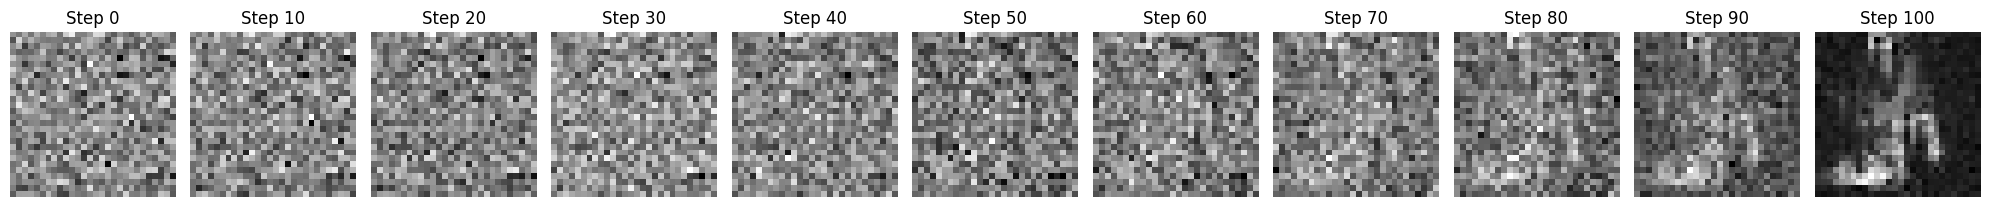

In [17]:
@torch.no_grad()
def sample_image(model, img_shape=(1, 28, 28)):
    model.eval()
    x = torch.randn((1, *img_shape)).to(device)
    images = []

    for t in reversed(range(T)):
        t_tensor = torch.tensor([t], device=device).float() / (T - 1)
        predicted_noise = model(x, t_tensor)
        
        alpha_t = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        beta_t = betas[t]

        scale = 1 / alpha_t.sqrt()
        noise_ratio = beta_t / (1 - alpha_cumprod_t).sqrt()
        x = scale * (x - noise_ratio * predicted_noise)
        
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = beta_t.sqrt()
            x += sigma_t * noise

        if t % 10 == 0 or t == T-1:
            images.append(x.cpu().numpy()[0,0])

    return images

# Visualize the denoising steps
sampled_images = sample_image(model)

fig, axes = plt.subplots(1, len(sampled_images), figsize=(20, 5))
for i, img in enumerate(sampled_images):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Step {i * (T // 10)}")
plt.tight_layout()
plt.show()


Diffusion steps: 10


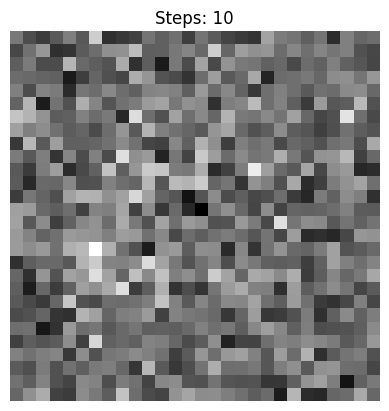

Diffusion steps: 30


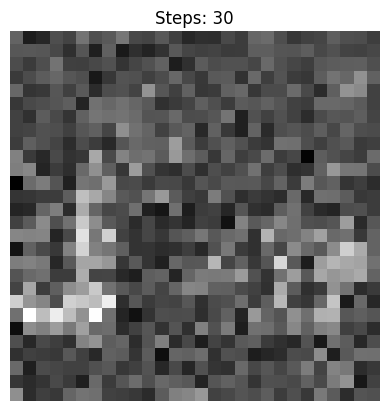

Diffusion steps: 100


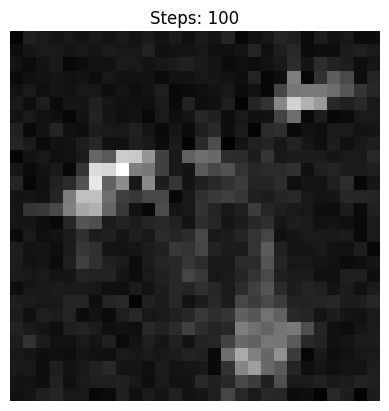

Diffusion steps: 500


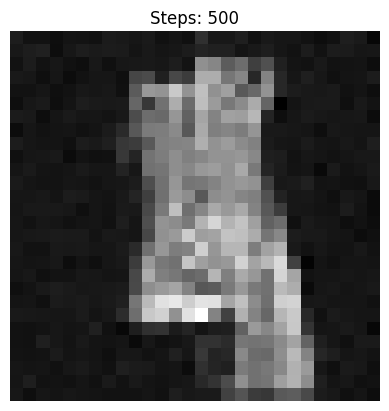

In [19]:
def experiment_diffusion_steps(model, steps_list=[10, 50, 100]):
    for steps in steps_list:
        print(f"Diffusion steps: {steps}")
        global T, betas, alphas, alphas_cumprod
        T = steps
        betas = torch.linspace(1e-4, 0.02, T).to(device)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        sampled_images = sample_image(model)
        plt.imshow(sampled_images[-1], cmap='gray')
        plt.title(f"Steps: {steps}")
        plt.axis('off')
        plt.show()

# Run experiment with different steps
experiment_diffusion_steps(model, steps_list=[10, 30, 100, 500])


## Advanced Practical Examples & Applications

TODO

## Conclusion and Next Steps

In this notebook, we:

- Introduced the basics of diffusion models.
- Built a simplified diffusion model on MNIST.
- Implemented the forward diffusion (noise addition) and reverse (denoising/sampling) processes.
- Trained the model while tracking loss with wandb.
- Sampled and visualized new images from our model.

**Next Steps:**
- Experiment with more complex architectures (e.g., U-Net) and datasets (CIFAR-10, CelebA).
- Explore conditional diffusion models and latent diffusion methods.
- Fine-tune hyperparameters and training strategies for improved sample quality.
- Review state-of-the-art implementations using the Hugging Face diffusers library.

Happy experimenting!
